In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
adult = fetch_openml("adult", version=2, as_frame=True)
df = adult.frame.copy()

df["target"] = (df["class"] == ">50K").astype(int)
df["sex"] = df["sex"].astype(str)

X = df.drop(columns=["class", "target"])
y = df["target"]
sensitive_feature = df["sex"]

X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive_feature, test_size=0.3, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Sex groups:", s_test.unique())

Train size: (34189, 14) Test size: (14653, 14)
Sex groups: ['Male' 'Female']


In [3]:
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=5000)),
    ]
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
overall_acc = accuracy_score(y_test, y_pred)
print("Overall accuracy:", overall_acc)

Overall accuracy: 0.8505425510134443


C:\Users\jmerom\AppData\Local\miniconda3\envs\aiops\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
results = []

for group in ["Female", "Male"]:
    mask = (s_test == group)
    y_true_g = y_test[mask]
    y_pred_g = y_pred[mask]
    
    acc_g = accuracy_score(y_true_g, y_pred_g)
    sel_rate_g = y_pred_g.mean()   # fraction predicted as 1 (approved)
    
    results.append({
        "sex": group,
        "accuracy": acc_g,
        "selection_rate": sel_rate_g,
    })

fair_df = pd.DataFrame(results).set_index("sex")
fair_df


,accuracy,selection_rate
sex,,
Female,0.927321,0.078649
Male,0.812474,0.245406


Selection rate disparity: 0.16675691624057687


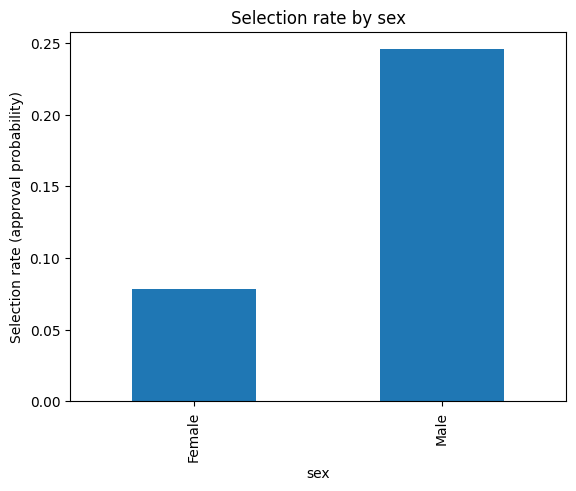

In [5]:
disparity = fair_df["selection_rate"].max() - fair_df["selection_rate"].min()
print("Selection rate disparity:", disparity)

fair_df["selection_rate"].plot(kind="bar")
plt.ylabel("Selection rate (approval probability)")
plt.title("Selection rate by sex")
plt.show()
